## Deep Learning Prediction

### Library imports

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

### Data import

In [2]:
DATA_PATH = "../data/"

path = DATA_PATH + "Telco_data_neural.csv"

In [3]:
df = pd.read_csv(path)

### Drop unused variables

In [4]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

### Fix Column names

In [5]:
df.columns = df.columns.str.replace(' ','_')

In [6]:
df.head().T

,0,1,2,3,4
Churn_Label,1,1,1,1,1
CLTV,5433,5302,3179,5337,2793
Referred_a_Friend,No,Yes,No,Yes,Yes
Number_of_Referrals,-0.650362,-0.317162,-0.650362,-0.317162,-0.317162
Tenure_in_Months,-1.2789,-0.993672,-0.586209,-0.300984,0.187973
Offer,None,Offer E,Offer D,Offer C,Offer C
Phone_Service,No,Yes,Yes,Yes,Yes
Avg_Monthly_Long_Distance_Charges,0,48.85,11.33,19.76,6.33
Multiple_Lines,No,Yes,Yes,No,Yes
Internet_Service,Yes,Yes,Yes,Yes,Yes


### Split the dataframe into train, validation, and test

In [7]:
train, test = train_test_split(df, test_size=0.2, shuffle=True)
train, val = train_test_split(train, test_size=0.2, shuffle=True)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

4507 train examples
1127 validation examples
1409 test examples


### Creating an input pipeline

In [8]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, target='Churn_Label', shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop(target)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [9]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

### Understanding the input pipeline

In [10]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of ages:', feature_batch['Age'])
  print('A batch of targets:', label_batch )

Every feature: ['CLTV', 'Referred_a_Friend', 'Number_of_Referrals', 'Tenure_in_Months', 'Offer', 'Phone_Service', 'Avg_Monthly_Long_Distance_Charges', 'Multiple_Lines', 'Internet_Service', 'Internet_Type', 'Avg_Monthly_GB_Download', 'Online_Security', 'Online_Backup', 'Device_Protection_Plan', 'Premium_Tech_Support', 'Streaming_TV', 'Streaming_Movies', 'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing', 'Payment_Method', 'Monthly_Charge', 'Total_Charges', 'Total_Refunds', 'Total_Extra_Data_Charges', 'Total_Long_Distance_Charges', 'Total_Revenue', 'City', 'Zip_Code', 'Latitude', 'Longitude', 'Gender', 'Age', 'Under_30', 'Senior_Citizen', 'Married', 'Dependents', 'Number_of_Dependents', 'Population', 'CityEncodedSortNormal']
A batch of ages: tf.Tensor([45 39 37 44 50], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([1 0 1 0 0], shape=(5,), dtype=int64)


### Example batch

In [11]:
# We will use this batch to demonstrate several types of feature columns
example_batch = next(iter(train_ds))[0]

In [12]:
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())


In [13]:
cltv = feature_column.numeric_column('CLTV')
demo(cltv)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[5633.]
 [3788.]
 [5706.]
 [5348.]
 [6468.]]


### Creating feature columns

In [23]:
feature_columns = []

# numeric cols
# for header in ['CLTV', 'Number_of_Referrals', 'Tenure_in_Months', 'Avg_Monthly_Long_Distance_Charges',  'Avg_Monthly_GB_Download',
#               'Monthly_Charge', 'Total_Charges', 'Total_Refunds', 'Total_Extra_Data_Charges', 'Total_Long_Distance_Charges', 'Total_Revenue', 
#               'Latitude', 'Longitude', 'Age', 'Number_of_Dependents', 'Population', 'CityEncodedSortNormal']:
#   feature_columns.append(feature_column.numeric_column(header))
for header in ['Number_of_Referrals', 'Avg_Monthly_Long_Distance_Charges',
              'Monthly_Charge', 'Total_Charges', 'Total_Refunds', 'Total_Long_Distance_Charges', 'Total_Revenue', 
              'Latitude', 'Number_of_Dependents', 'Population', 'CityEncodedSortNormal', 'Tenure_in_Months']:
  feature_columns.append(feature_column.numeric_column(header))

In [24]:
# # bucketized cols
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=[18, 29, 65, 80])
feature_columns.append(age_buckets)


cltv = feature_column.numeric_column('CLTV')
cltv_buckets = feature_column.bucketized_column(cltv, boundaries=[2000, 3000, 4000, 5000, 6000, 6500])
feature_columns.append(cltv_buckets)

# tenure = feature_column.numeric_column('Tenure_in_Months')
# tenure_buckets = feature_column.bucketized_column(tenure, boundaries=[0, 1, 5, 10, 20, 30, 40, 60, 70, 72])
# feature_columns.append(tenure_buckets)

In [25]:
# indicator_columns
indicator_column_names = ['Referred_a_Friend', 'Offer', 'Phone_Service', 'Multiple_Lines', 'Internet_Service', 'Internet_Type', 
                         'Online_Security', 'Online_Backup', 'Device_Protection_Plan', 'Premium_Tech_Support', 'Streaming_TV', 
                         'Streaming_Movies', 'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing', 
                         'Payment_Method', 'Under_30', 'Senior_Citizen', 'Married', 'Dependents']
for col_name in indicator_column_names:
      categorical_column = feature_column.categorical_column_with_vocabulary_list(
            col_name, df[col_name].unique())
      indicator_column = feature_column.indicator_column(categorical_column)
      feature_columns.append(indicator_column)

In [26]:
# embedding columns
# embedding_column_names = ['City', 'Zip_Code']
# for col_name in embedding_column_names:
#     embedding_column = feature_column.categorical_column_with_vocabulary_list(
#         col_name, df[col_name].unique())
# #     print(embedding_column)
#     col_name_embedding = feature_column.embedding_column(col_name, dimension=8)
#     feature_columns.append(col_name_embedding)
    
# city = feature_column.categorical_column_with_vocabulary_list(
#       'City', df.City.unique())
# city_embedding = feature_column.embedding_column(city, dimension=8)
# feature_columns.append(city_embedding)

# zip_code = feature_column.categorical_column_with_vocabulary_list(
#       'Zip_Code', df.Zip_Code.unique())
# zip_code_embedding = feature_column.embedding_column(zip_code, dimension=3)
# feature_columns.append(zip_code_embedding)

# city_hashed = feature_column.categorical_column_with_hash_bucket(
#       'City', hash_bucket_size=5)
# feature_columns.append(feature_column.indicator_column(city_hashed))

# zip_code_hashed = feature_column.categorical_column_with_hash_bucket(
#       'Zip_Code', hash_bucket_size=5)
# feature_columns.append(feature_column.indicator_column(zip_code_hashed))


### Create a feature layer

In [27]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [28]:
batch_size = 64
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [32]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='sigmoid', activity_regularizer=regularizers.l1(1e-3)),
  layers.Dense(64, activation='sigmoid', activity_regularizer=regularizers.l1(1e-3)),
#   layers.Dense(32, activation='sigmoid', activity_regularizer=regularizers.l1(1e-5)),
#   layers.Dense(16, activation='sigmoid', activity_regularizer=regularizers.l1(1e-5)),
  layers.Dropout(0.1),
  layers.Dense(1, activation="sigmoid")
])

# model = tf.keras.Sequential([
#   feature_layer,
#   layers.Dense(128, activation='sigmoid'),
#   layers.Dense(64, activation='sigmoid'),
#   layers.Dense(32, activation='sigmoid'),
# #   layers.Dense(16, activation='sigmoid', activity_regularizer=regularizers.l1(1e-5)),
#   layers.Dropout(0.1),
#   layers.Dense(1, activation="sigmoid")
# ])
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=2,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)


model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# history = model.fit(train_ds,
#           validation_data=val_ds,
#           epochs=30, callbacks=[callback])

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=30)

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
69/71 [============================>.] - ETA: 0s - loss: 0.6552 - accuracy: 0.7101WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fa7f8fbd710> and will run it as-is.
Please report this to the 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Consider rewriting this model with the Functional API.
71/71 [==============================] - 1s 12ms/step - loss: 0.6542 - accuracy: 0.7102 - val_loss: 0.5848 - val_accuracy: 0.7294
Epoch 2/30
71/71 [==============================] - 0s 4ms/step - loss: 0.5271 - accuracy: 0.7766 - val_loss: 0.4802 - val_accuracy: 0.8021
Epoch 3/30
71/71 [==============================] - 0s 4ms/step - loss: 0.4589 - accuracy: 0.8170 - val_loss: 0.4370 - val_accuracy: 0.8279
Epoch 4/30
71/71 [==============================] - 0s 4ms/step - loss: 0.4387 - accuracy: 0.8260 - val_loss: 0.4174 - val_accuracy: 0.8412
Epoch 5/30
71/71 [==============================] - 0s 4ms/step - loss: 0.4207 - acc

In [33]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

23/23 [==============================] - 0s 4ms/step - loss: 0.3530 - accuracy: 0.8517
Accuracy 0.8516678214073181


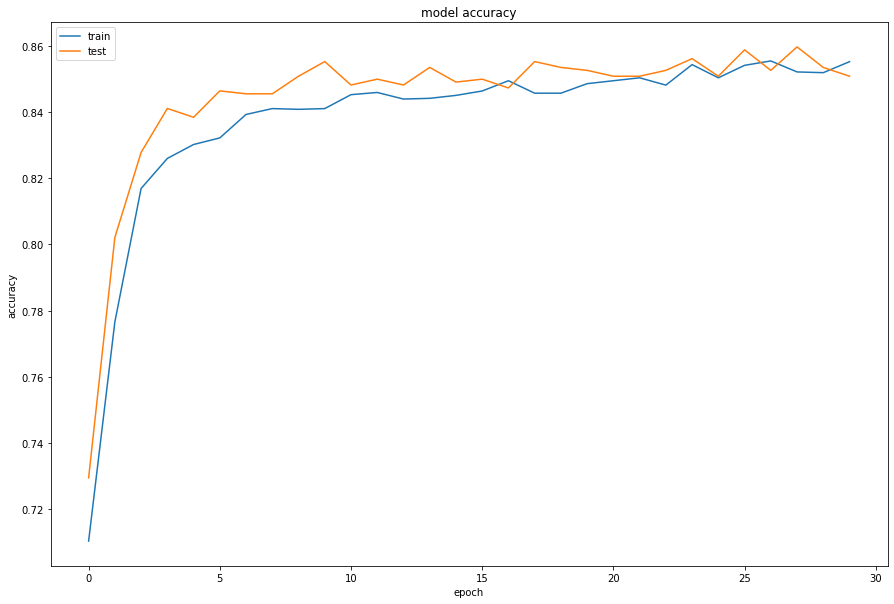

In [34]:
plt.figure(figsize=(15,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()